In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.insert(0, "/SSF")

In [2]:
from pathlib import Path
from failure_dependency_graph import FDG
fdg = FDG.load(Path("/SSF/data/A1"))

Using backend: pytorch
2022-03-14 02:49:36.934 | INFO     | failure_dependency_graph.failure_dependency_graph:_load_FDG:206 - Loading FDG from /SSF/data/A1/FDG.pkl


In [3]:
from metric_preprocess import MetricPreprocessor
mp = MetricPreprocessor(fdg)

preprocess metrics for each instance type: 100%|██████████| 19/19 [00:06<00:00,  3.10it/s]


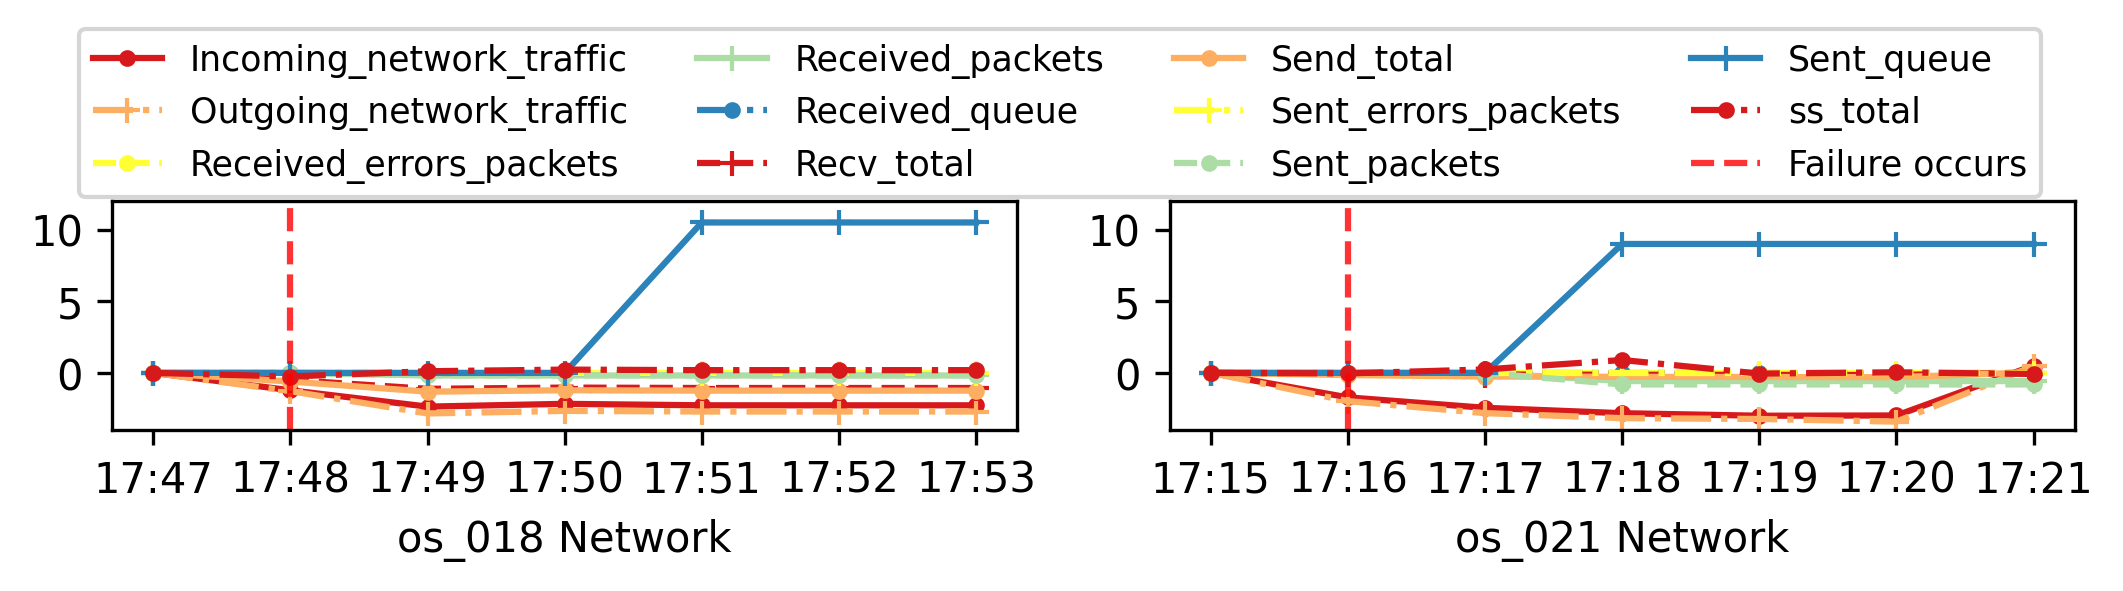

In [89]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from explib.legend import get_line_style

fig, axes = plt.subplots(1, 2, dpi=300, figsize=(7.2, 1.5))
myFmt = mdates.DateFormatter('%H:%M')


def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

def plot_metrics(fid, ax):
    rc = fdg.root_cause_instances_of(fid)[0]
    fc, lid = fdg.instance_to_local_id(rc)
    fc_id = fdg.failure_classes.index(fc)
    metric_names = fdg.FI_metrics_dict[rc]
    metric_values = mp(fault_ts=fdg.failure_at(fid)["timestamp"], window_size=(1, 6), batch_normalization=True)[fc_id][lid]
    # print(f"{metric_values.shape=}")
    x = [datetime.fromtimestamp(_) for _ in range(fdg.failure_at(fid)["timestamp"] - 60 * 1, fdg.failure_at(fid)["timestamp"] + 60 * 6, 60)]
    for metric_name, metric_value in zip(metric_names, metric_values):
        # print(x, metric_value.tolist())
        ax.plot(x, metric_value.tolist(), label=metric_name.split("##")[1], **get_line_style(metric_name.split('##')[1]))
    ax.set_yticks([0, 5, 10])
    ax.set_ylim([-4, 12])
    ax.axvline(datetime.fromtimestamp(fdg.failure_at(fid)["timestamp"]), label="Failure occurs", color='red', linestyle='--', alpha=0.8, )
    ax.set_xlabel(rc)
    ax.legend()
    ax.legend_.set_visible(False)
    ax.xaxis.set_major_formatter(myFmt)
        
plot_metrics(14, axes[0])
plot_metrics(20, axes[1])
fig.legend(*axes[1].get_legend_handles_labels(), bbox_to_anchor=(0.96, 1.32), ncol=4, fontsize="small")
plt.tight_layout()
plt.savefig("/SSF/output/local_interpretation_example.pdf", bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

In [25]:
fdg.failure_at(14)

timestamp                           1590083280
object                                      os
fault_description                network delay
kpi                  Sent_queue;Received_queue
name                                    os_018
node_type                           OS Network
root_cause_node                 os_018 Network
Name: 14, dtype: object